In [6]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
# load the data

train_data = pd.read_csv('gdrive/MyDrive/aug_train.csv') 


In [10]:
#exploratory data analysis

train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [11]:
train_data.shape

(19158, 14)

In [12]:
#It looks like some values in the dataset are NaN, we would like to further inspect to which extent it affects our data.

print("Missing values in the train dataset:\n\n",train_data.isna().sum())

Missing values in the train dataset:

 enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


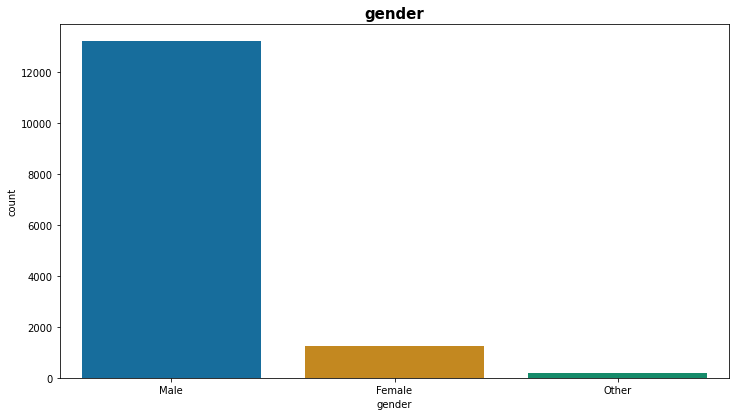

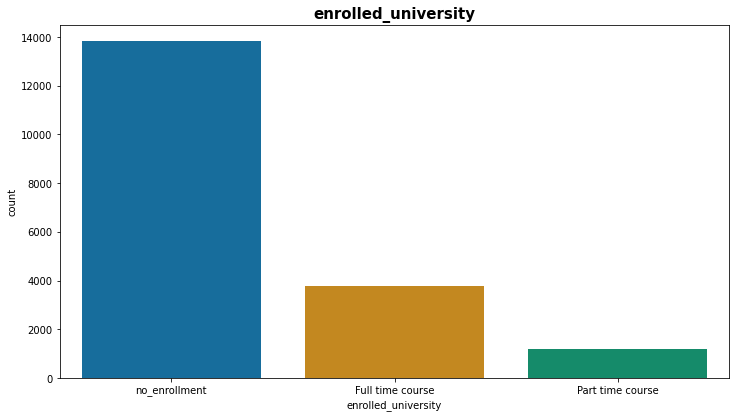

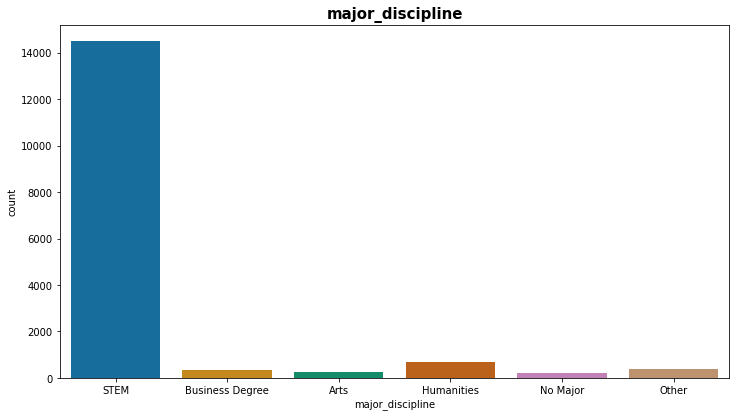

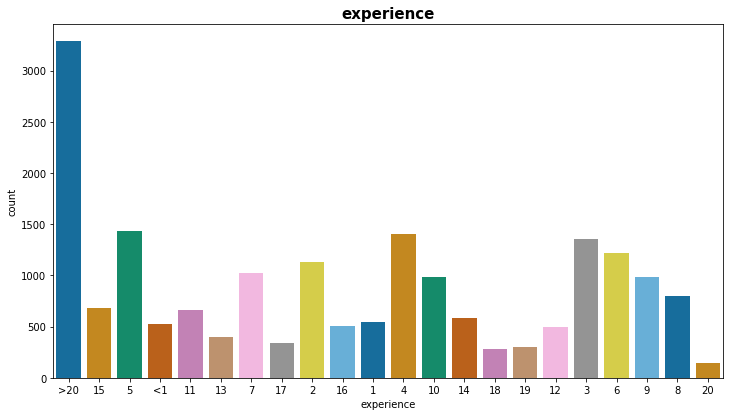

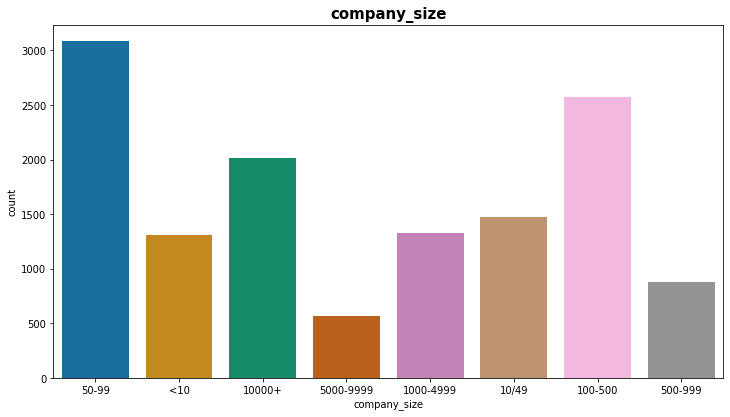

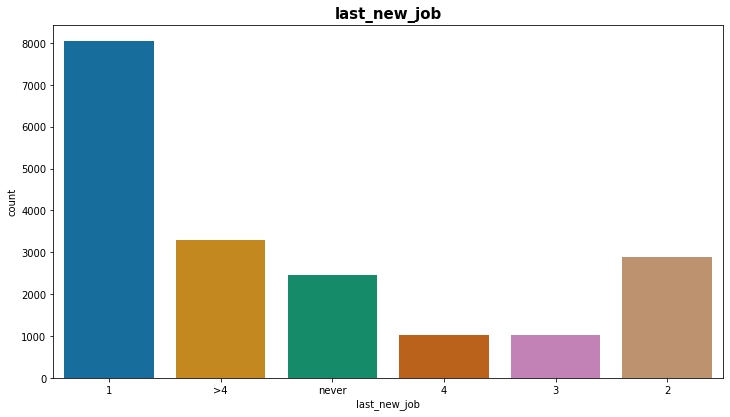

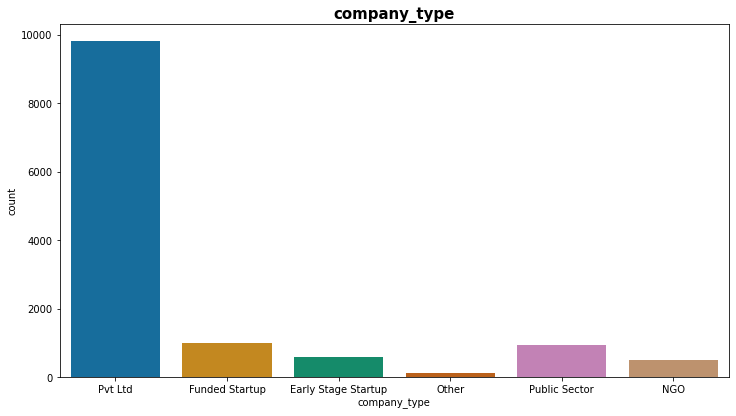

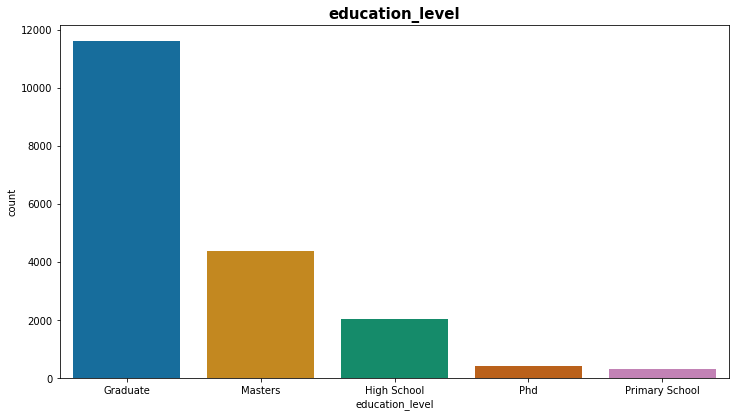

In [13]:
#Let's plot all the column into barcharts to see the distribution of values. As we want our chart to be accesible, we will use colorblind palette.

cols_with_nan_data = train_data[['gender', 'enrolled_university', 'major_discipline', 'experience', 'company_size', 'last_new_job', 'company_type', 'education_level']]   
colorblind_palette = sns.color_palette("colorblind")

for i in cols_with_nan_data:
    plt.figure(figsize=(12,6.5)) 
    plt.title(i, fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
    sns.countplot(data = train_data[i], x = cols_with_nan_data[i], palette=colorblind_palette)
    plt.show()

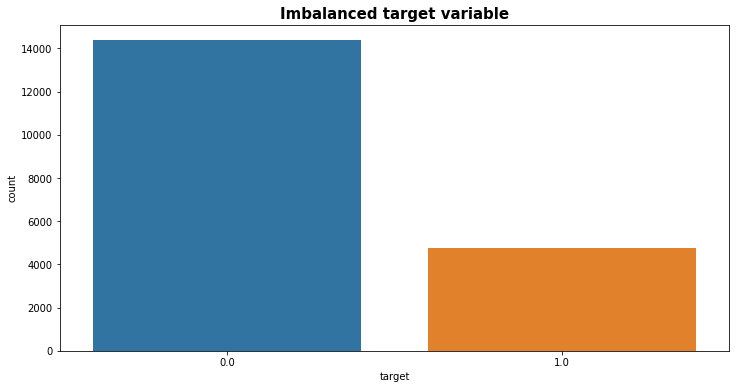

In [14]:
# We are also interested in whether the target variable is balanced or not.

plt.figure(figsize=(12,6))
plt.title("Imbalanced target variable", fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
ax = sns.countplot(x='target', data=train_data)

In [15]:
# Handling null values

data=train_data
data.shape

(19158, 14)

In [16]:
# Now we will take care of all attributes with NaN values as shown in graphs above.

data['city'] = data['city'].str.split("_",expand=True)[1].astype('int64')
data['gender'] = data['gender'].replace(np.nan, 'Male')
data['enrolled_university'] = data['enrolled_university'].replace(np.nan, 'no_enrollment')
data['education_level'] = data['education_level'].replace(np.nan,'Graduate')
data['major_discipline'] = data['major_discipline'].replace(np.nan,'STEM')
data['experience'] = data['experience'].replace(np.nan,'>20')
data['company_size'] = data['company_size'].replace(np.nan,'50-99')
data['company_type'] = data['company_type'].replace(np.nan,'Pvt Ltd')
data['last_new_job'] = data['last_new_job'].replace(np.nan,'1')

In [17]:
# Since value 'Other' has very low frequency in gender attribute, we will get rid of it.

data = data[data.gender != 'Other']

In [18]:
data.shape

(18967, 14)

In [19]:
# We've successfully replaced all NaN values:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18967 non-null  int64  
 1   city                    18967 non-null  int64  
 2   city_development_index  18967 non-null  float64
 3   gender                  18967 non-null  object 
 4   relevent_experience     18967 non-null  object 
 5   enrolled_university     18967 non-null  object 
 6   education_level         18967 non-null  object 
 7   major_discipline        18967 non-null  object 
 8   experience              18967 non-null  object 
 9   company_size            18967 non-null  object 
 10  company_type            18967 non-null  object 
 11  last_new_job            18967 non-null  object 
 12  training_hours          18967 non-null  int64  
 13  target                  18967 non-null  float64
dtypes: float64(2), int64(3), object(9)
mem

In [20]:
# Conversion of categorical variables into numeric variables

pd.options.mode.chained_assignment = None
ordinal_atributes = ['education_level', 'experience', 'company_size', 'last_new_job']

cardinal_atributes = ['gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']

ordinal_pipeline = Pipeline([
    ('OrdinalEncoder',OrdinalEncoder(categories=[
                                    ['Unknown', 'Primary School',  'High School', 'Graduate', 'Masters', 'Phd'],
                                    'Unknown,<1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,>20'.split(','),
                                    ['Unknown','<10', '10/49', '50-99', '100-500', '500-999' ,'1000-4999', '5000-9999', '10000+'],
                                    ['Unknown','1', '2', '3', '4', '>4', 'never']
                                ]))
])

ordinal_pipeline.fit(data[ordinal_atributes])
data[ordinal_atributes] = ordinal_pipeline.transform(data[ordinal_atributes])
data = pd.get_dummies(data, columns=cardinal_atributes)
data.head()

,enrollee_id,city,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,gender_Female,...,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,8949,103,0.920,3.0,22.0,3.0,1.0,36,1.0,0,...,0,0,0,1,0,0,0,0,0,1
1,29725,40,0.776,3.0,16.0,3.0,5.0,47,0.0,0,...,0,0,0,1,0,0,0,0,0,1
2,11561,21,0.624,3.0,6.0,3.0,6.0,83,0.0,0,...,0,0,0,1,0,0,0,0,0,1
3,33241,115,0.789,3.0,1.0,3.0,6.0,52,1.0,0,...,0,0,0,0,0,0,0,0,0,1
4,666,162,0.767,4.0,22.0,3.0,4.0,8,0.0,0,...,0,0,0,1,0,1,0,0,0,0


In [21]:
# Let's check how many columns do we have at this moment.

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 0 to 19157
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   enrollee_id                                  18967 non-null  int64  
 1   city                                         18967 non-null  int64  
 2   city_development_index                       18967 non-null  float64
 3   education_level                              18967 non-null  float64
 4   experience                                   18967 non-null  float64
 5   company_size                                 18967 non-null  float64
 6   last_new_job                                 18967 non-null  float64
 7   training_hours                               18967 non-null  int64  
 8   target                                       18967 non-null  float64
 9   gender_Female                                18967 non-null  uint8  
 10

In [23]:
# Balancing target variable

#To balance our target variable, we will use RandomOverSampler from imblearn library.

columns = data.columns.tolist()
columns = [c for c in columns if c not in ['target']]
y = data['target']
X = data[columns]

ros = RandomOverSampler(sampling_strategy='minority')
X_ros, y_ros = ros.fit_resample(X, y)
print(f"Imbalanced target class: {Counter(y)}\n\nBalanced target class: {Counter(y_ros)}\n")
print(X_ros.shape[0] - data.shape[0], 'new random picked points')

Imbalanced target class: Counter({0.0: 14240, 1.0: 4727})

Balanced target class: Counter({1.0: 14240, 0.0: 14240})

9513 new random picked points


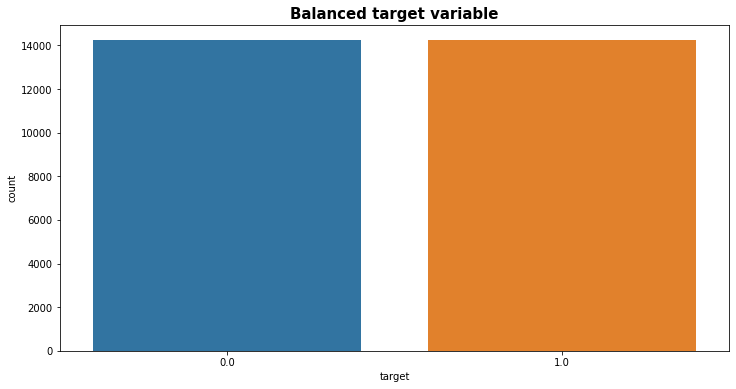

In [24]:
# We can see our result in barchart below

plt.figure(figsize=(12,6))
plt.title("Balanced target variable", fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
ax = sns.countplot(x=y_ros, data=data)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 0 to 19157
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   enrollee_id                                  18967 non-null  int64  
 1   city                                         18967 non-null  int64  
 2   city_development_index                       18967 non-null  float64
 3   education_level                              18967 non-null  float64
 4   experience                                   18967 non-null  float64
 5   company_size                                 18967 non-null  float64
 6   last_new_job                                 18967 non-null  float64
 7   training_hours                               18967 non-null  int64  
 8   target                                       18967 non-null  float64
 9   gender_Female                                18967 non-null  uint8  
 10

In [26]:
data.shape

(18967, 28)

In [31]:
# model
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.3,stratify=y,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((13276, 27), (5691, 27), (13276,), (5691,))

In [32]:
# KNN

knnc = KNeighborsClassifier(n_neighbors=4)
knnc.fit(X_train, y_train)
y_pred_knnc = knnc.predict(X_test)

print(classification_report(y_test, y_pred_knnc))
print('The accuracy score with using the KNN is :',accuracy_score(y_test,y_pred_knnc))

              precision    recall  f1-score   support

         0.0       0.76      0.94      0.84      4273
         1.0       0.40      0.12      0.18      1418

    accuracy                           0.74      5691
   macro avg       0.58      0.53      0.51      5691
weighted avg       0.67      0.74      0.68      5691

The accuracy score with using the KNN is : 0.7360745036021789


In [46]:
#hyperparameter tuning
params = {'n_neighbors': np.arange(1, 31, 2), "metric": ["euclidean"]}
grid_search_cv = GridSearchCV(KNeighborsClassifier(), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
# returns the best model
#grid_search_cv.best_estimator_

# the best parameters
grid_search_cv.best_params_
# results obtained by the best model
knn_accuracy = grid_search_cv.best_score_ 
print('The accuracy score with using the tuned KNN is: ', knn_accuracy)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
The accuracy score with using the tuned KNN is:  0.7522597253176956


In [44]:
# decision tree

dtc = DecisionTreeClassifier(max_depth = 3, random_state=0)

dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)
#metrics.accuracy_score(y_test, y_pred_dtc)

print(classification_report(y_test, y_pred_dtc))
print('The accuracy score with using the decision tree classifier is :',accuracy_score(y_test,y_pred_dtc))

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      4273
         1.0       0.59      0.44      0.50      1418

    accuracy                           0.78      5691
   macro avg       0.71      0.67      0.68      5691
weighted avg       0.77      0.78      0.77      5691

The accuracy score with using the decision tree classifier is : 0.7829906870497276


In [45]:
# hyper parametuning

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
# returns the best model
grid_search_cv.best_estimator_
# the best parameters
grid_search_cv.best_params_
# results obtained by the best model
dt_accuracy = grid_search_cv.best_score_ 
print('The accuracy score with using the tuned decision tree classifier is: ', dt_accuracy)


Fitting 3 folds for each of 294 candidates, totalling 882 fits
The accuracy score with using the tuned decision tree classifier is:  0.7823893054481181


In [37]:
#RANDOM FOREST

rfc = RandomForestClassifier(n_estimators = 50, class_weight = {0:1, 1:4})
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print(classification_report(y_test, y_pred_rfc))
print('The accuracy score with using the Random Forest is :',accuracy_score(y_test,y_pred_rfc))

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.85      4273
         1.0       0.55      0.34      0.42      1418

    accuracy                           0.77      5691
   macro avg       0.68      0.63      0.64      5691
weighted avg       0.74      0.77      0.75      5691

The accuracy score with using the Random Forest is : 0.767351959233878


In [48]:
params = {'max_leaf_nodes': list(range(2, 20)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

grid_search_cv.best_estimator_
grid_search_cv.best_params_
rf_accuracy = grid_search_cv.best_score_ 
print('The accuracy score with using the tuned Random Forest is :',rf_accuracy)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
The accuracy score with using the tuned Random Forest is : 0.7695089366634243


In [41]:
# XGB Classifier

xgbc = XGBClassifier(use_label_encoder=False)
xgbc.fit(X_train,y_train)
xgb_accuracy = accuracy_score(y_test,xgbc.predict(X_test))
print('The accuracy using the XGBclassifier is :', xgb_accuracy)

The accuracy using the XGBclassifier is : 0.7812335266209804


In [49]:
# comparision of models

accuracies = {"Decision Tree Accuracy":dt_accuracy,  "Random Forest Accuracy":rf_accuracy, "XGB Accuracy":xgb_accuracy, "KNN Accuracy":knn_accuracy}
print("The best score has the model: ", max(accuracies, key=accuracies.get))

The best score has the model:  Decision Tree Accuracy


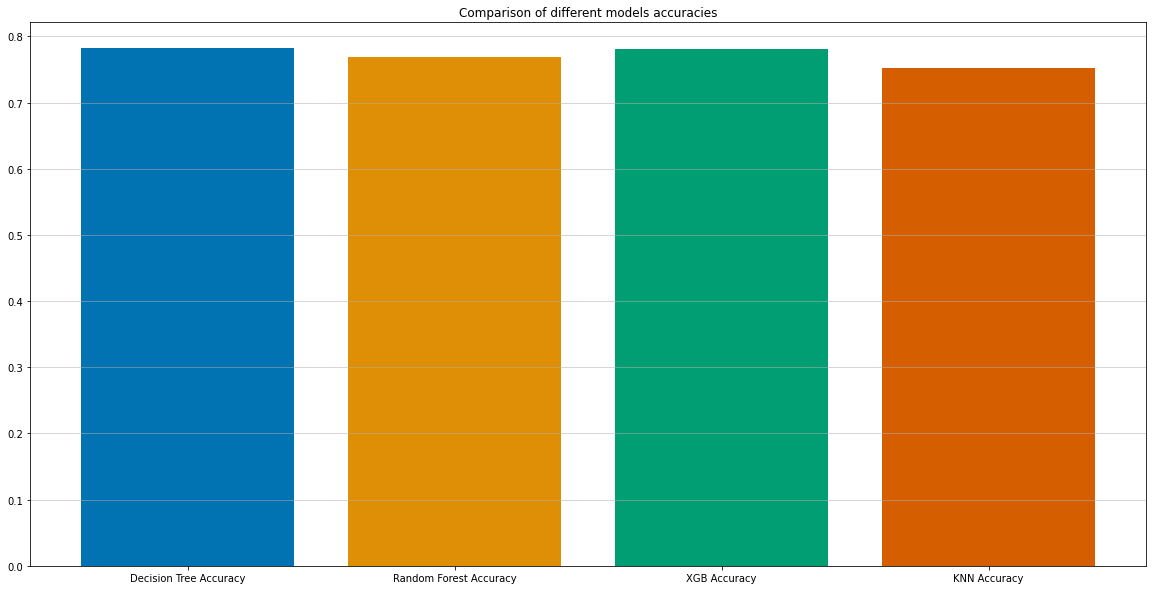

In [51]:
# check how good were the other ones
plt.figure(figsize=(20,10))
plt.bar(*zip(*accuracies.items()), color=colorblind_palette, width = 0.8)
plt.title("Comparison of different models accuracies")
plt.grid(axis = 'y', linewidth = 0.5)
plt.show()